Gillespie Algorithm:  
Active -> $\mu$ -> mRNA -> $d$ -> Degrade

Below is an implementation I found here: http://be150.caltech.edu/2019/handouts/12_stochastic_simulation_all_code.html of the Gillespie algorithm. It's quite suited for our needs I think and could be modified a bit. The original code deals with mRNA copies and Protein numbers. I modified the code below that to uninclude the protein numbers and only to deal with the mRNA copies.

 for each step, you decide on how long it will take for the next reaction to occur, using an exponential distribution. Then you decide on what reaction to have occur right now based on the current propensities, and make the change to the population, advance by the timestep, calculatea new timestep, calculate new propensities then decide the reaction again, change the population, advance by the timestep, repeat

<Axes: ylabel='Count'>

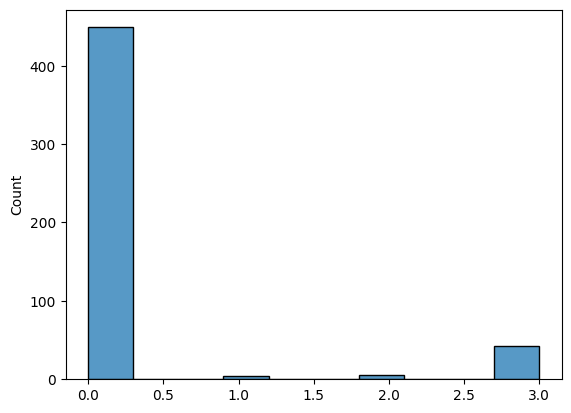

In [12]:
import scipy.stats as st
import seaborn as sns

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

probs = [0.9, 0.01, 0.01, 0.08]
result = []
for i in range(500):
    result.append(sample_discrete_scipy(probs))

sns.histplot(result)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def gillespie_mrna_production(mu, d, M0, T_max):
    """
    Simulates mRNA transcription and degradation using the Gillespie SSA.

    Parameters:
        mu (float): Transcription rate (mRNA production per unit time)
        d (float): Degradation rate (per mRNA per unit time)
        M0 (int): Initial mRNA count
        T_max (float): Maximum simulation time

    Returns:
        times (list): Time points of reactions
        mRNA_counts (list): Corresponding mRNA counts
    """
    times = [0]  # Time points
    mRNA_counts = [M0]  # mRNA molecule counts

    M = M0  # Initial mRNA count
    t = 0  # Initial time

    while t < T_max:
        # Compute propensities
        a1 = mu  # Production rate
        a2 = d * M  # Degradation rate
        a_total = a1 + a2

        if a_total == 0:
            break

        # Compute time until next reaction
        tau = -np.log(np.random.rand()) / a_total

        # Choose which reaction occurs
        if np.random.rand() * a_total < a1:
            M += 1  # Transcription event
        else:
            M = max(0, M - 1)  # Degradation event (mRNA can't go below 0)

        # Update time and save state
        t += tau
        times.append(t)
        mRNA_counts.append(M)

    return times, mRNA_counts


In [14]:
import tqdm
import bokeh
import numpy as np

# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0],   # Make mRNA transcript
                          [-1, 0],  # Degrade mRNA
                          [0, 1],   # Make protein
                          [0, -1]], # Degrade protein
                         dtype=int)

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1 # This is returning the reaction event that will occur

def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m           # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p   # Degrade protein

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time



def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out 

In [15]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)

C:\Users\joeot\AppData\Local\Temp\ipykernel_4284\728577036.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
import bokeh.plotting as bp
# Set up plots
plots = [bp.figure(width=300,
                               height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of mRNAs'),
         bp.figure(width=300,
                               height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of proteins')]

# Plot trajectories and mean
for i in [0, 1]:
    for x in samples[:,:,i]:
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=6, color='orange', line_join='bevel')

# Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

# JUST mRNA

In [17]:
import tqdm
import bokeh
import numpy as np

# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1], [-1]], dtype=int)  # Make mRNA transcript, Degrade mRNA transcript
                          
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1 # This is returning the reaction event that will occur

def simple_propensity(propensities, population, t, beta_m, gamma_m):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m = population[0]
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m * gamma_m # Degrade mRNA

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time



def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), 1), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population[0] += update[event, 0]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out 

This served as a good base, model but some things I still don't fully understand, such as the dimensionless time aspect. If this is dimensionless, I am unsure how to get proper beta and gamma coefficients considering theres no time.

The sedimentation profiles of mRNA from HeLa and CHO cells indicate that the lengths of mammalian mRNA are lognormally distributed with a median value of 1.4 kb and a deviation of 2.0. This implies that, on the average, a mRNA species is only about 25% larger than the mature polypeptide it codes for. [https://link.springer.com/article/10.1007/BF01732582]

Could use this result to but in a good value for $\beta_m$
Could tailor this rate to deal with certain specific proteins we know the mRNA length of?
Maybe deal with the degradation rate in a similar way? [https://pmc.ncbi.nlm.nih.gov/articles/PMC403777/]

Unsure if this is the right direction to be going in for the model.


In [18]:
# Specify parameters for calculation
beta_mrna = 10.0
gamma_mrna = 0.1 # degradation rate

args = (beta_mrna, gamma_mrna)
time_points = np.linspace(0, 500, 1001)
population_0 = np.array([0], dtype=int)
size = 10

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 1), dtype=int)

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    samples[i,:,0] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)[:, 0]

C:\Users\joeot\AppData\Local\Temp\ipykernel_4284\1458198620.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span

output_notebook()
# Set up plot for mRNA only
plot = bp.figure(width=600,
                 height=400,
                 title=f"mRNA counts with Beta {beta_mrna}, Gamma {gamma_mrna}",
                 x_axis_label='dimensionless time',
                 y_axis_label='number of mRNAs')

# Plot multiple trajectories
for x in samples[:, :, 0]:
    plot.line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel')

# Plot the mean trajectory
plot.line(time_points, samples[:, :, 0].mean(axis=0),
          line_width=4, color='orange', line_join='bevel', legend_label="mRNA Counts")

steady_state = beta_mrna / gamma_mrna

# Horizontal line
hline = Span(location=steady_state, dimension='width', line_color='red', line_width=2)

plot.renderers.extend([hline])


show(plot)

Loading BokehJS ...

# Trying things that didn't quite work:

In [20]:
import numpy as np

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def compute_propensities(propensities, population):
    propensities[1] *= population # Only degradation depends on population of mRNA
    return propensities

def my_gillespie(init_mrna, mu, d, max_time):
    ''' init_mrna is the initial amount of mrna, mu is the rate of mrna synthesis
    d is the degradation rate'''
    propensities = [mu, d]
    a_total = sum(propensities)**-1
    time_interval = np.random.exponential(a_total) # sample a random number from an exponential distribution with mean (∑ai)^−1
    probs = propensities / a_total  # Normalize propensities to sum to 1

def gillespie_draw(compute_propensities, propensities, population, t, args=()):
       # Compute propensities
    compute_propensities(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out


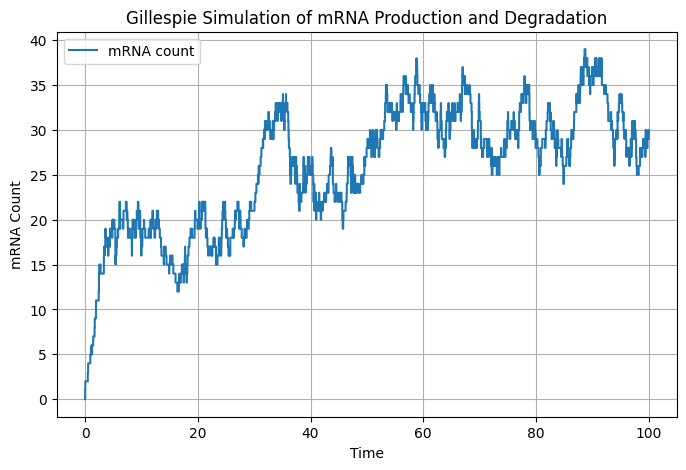

In [21]:
# Parameters
mu = 5.0  # Transcription rate (per unit time)
d = 0.2   # Degradation rate (per mRNA per unit time)
M0 = 0    # Initial mRNA count
T_max = 100  # Simulation time

# Run Gillespie simulation
times, mRNA_counts = gillespie_mrna_production(mu, d, M0, T_max)

# Plot results
plt.figure(figsize=(8,5))
plt.step(times, mRNA_counts, where='post', label="mRNA count")
plt.xlabel("Time")
plt.ylabel("mRNA Count")
plt.title("Gillespie Simulation of mRNA Production and Degradation")
plt.legend()
plt.grid()
plt.show()